## 1. Dataset and Knowledge Preparation

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
import sklearn.model_selection

notebook_start_time = time.time()

sensor_data_full = pd.read_excel('sensor_data.xlsx')

# Display a sample of the data
sensor_data_full.sample(5)

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
3033,2.1,1302.50,11.012100,1014.750000,139.0,776.750000,96.0,1730.75,1250.000000,23.650001,40.000000,1.152962
681,1.9,1079.00,8.822004,932.333333,311.8,718.666667,183.6,1018.00,1055.666667,11.366666,32.566666,0.437303
1949,2.7,1140.25,14.166107,1122.000000,262.0,619.250000,103.0,1601.50,1208.000000,19.650000,64.474999,1.459394
2766,0.8,999.75,3.594138,687.750000,55.0,1257.000000,61.0,1398.00,425.750000,14.200000,58.625001,0.944347
386,2.6,1061.75,8.080705,902.500000,270.2,717.000000,190.0,1141.00,719.750000,4.225000,77.750000,0.649102


## 2. Linear Classification via Gradient Descent 

The air quality is assessed using the CO(GT) variable. If it is no greater than 4.5, the air quality is good (CO(GT)<=4.5), otherwise, it is bad  (CO(GT)>4.5). 

### 2.1 Model Training and Testing

This practice is about training a binary linear classifier by minimising a hinge loss with L2 (ridge) regularisation, and then testing its performance. Given a set of $N$ training samples $\{(\mathbf{x}_i, y_i)\}_{i=1}^N$, where $\mathbf{x}_i$ is the feature vector and $y_i \in \{-1, +1\}$ is the class label for the $i$-th training sample, the training objective function to minimise is 
$$O = C \sum^N_{i=1}\max\left(0, 1 - y_i \left(\mathbf{w}^T\mathbf{x}_i + w_0\right)\right) + \frac{1}{2}\mathbf{w}^T\mathbf{w}. $$
Here, $\mathbf{w}$ is a column weight vector of the linear model, $w_0$ is the bias parameter of the model, and $C$ is the regularisation hyperparameter.

In [8]:
def linear_gd_train(data, labels, c=0.2, n_iters=200, learning_rate=0.001, random_state=None
          ):
    """
    A summary of your function goes here.

    data: training data
    labels: training labels (boolean)
    c: regularisation parameter
    n_iters: number of iterations
    learning_rate: learning rate for gradient descent

    Returns an array of cost and model weights per iteration.
    """
    # Set random seed for reproducibility if using random initialisation of weights (optional)
    rng = np.random.default_rng(seed=random_state)

    # Create design matrix and labels
    X_tilde = np.concatenate((np.ones((data.shape[0], 1)), data), axis=-1)
    y = np.where(labels <=0, -1, 1)

    # Weight initialisation: use e.g. rng.standard_normal() or all zeros
    w = np.zeros(X_tilde.shape[1])
    w0 = 0

    # Initialise arrays to store weights and cost at each iteration
    w_all = np.zeros((1,X_tilde.shape[1]))
    cost_all = []
    
    # GD update of weights
    for i in range(n_iters):
        gd = 0
        bgd = 0
        cost = 0
        for index, x_i in enumerate(X_tilde):
            condition = y[index] * (np.dot(w_all[i].T,x_i) + w0) >=1
            if(condition):
                gd += 0
                bgd += 0
                cost += 0
            else:
                gd += np.dot(-y[index],x_i)
                bgd += -y[index]
                cost += 1-y[index]*(np.dot(w_all[i].T,x_i)+w0)

        dw = c*(gd) + w_all[i]
        dw0 = c*bgd + w0

        w = w_all[i] - learning_rate * dw
        w0 = w0 - learning_rate * dw0
        cost = c * cost + (np.dot(w_all[i].T,w_all[i]))/2
            
        # save w and cost of each iteration in w_all and cost_all
        cost_all.append(cost)
        w_c = np.reshape(w, (1,X_tilde.shape[1]))
        w_all = np.concatenate((w_all, w_c), axis=0)
    
    # Return model parameters.
    return cost_all, w_all


def linear_predict(data, w):
    """
    A summary of your function goes here.

    data: test data
    w: model weights

    Returns the predicted labels.
    """

    X_tilde = np.concatenate((np.ones((data.shape[0], 1)), data), axis=-1)
    y_pred = X_tilde @ w.T

    predicted_labels = np.sign(y_pred)

    y = np.where(predicted_labels <= -1, -1, 1)
    
    return y

In [9]:
from sklearn.impute import SimpleImputer

# Put a threshold on the labels to cast to binary: True if CO(GT) > 4.5, False otherwise
binary_targets = (sensor_data_full['CO(GT)'] > 4.5).to_numpy()
sensor_data = sensor_data_full.drop(columns=['CO(GT)']).to_numpy()

# Named _cls to keep our classification experiments distinct from regression
train_X_cls, test_X_cls, train_y_cls, test_y_cls = sklearn.model_selection.train_test_split(sensor_data, binary_targets, test_size=0.15, stratify=binary_targets)

# Impute missing values and standardise the data
imputer = SimpleImputer(missing_values=-999, strategy='mean')
scaler = sklearn.preprocessing.StandardScaler()

train_X_cls = imputer.fit_transform(train_X_cls)
train_X_cls = scaler.fit_transform(train_X_cls)

In [10]:
def model_accuracy(y_pred, y_actual):
    assert(len(y_actual) == len(y_pred))
    correct = 0
    for i in range(len(y_actual)):
        if(y_pred[i] == -1 and y_actual[i] == False):
            correct += 1
            continue
        if(y_actual[i] == y_pred[i]):
            correct += 1
    return correct/len(y_actual)

def precision(y_pred, y_actual):
    assert(len(y_actual) == len(y_pred))
    tp = 0
    fp = 0
    for i in range(len(y_actual)):
        if(y_pred[i] == -1):
            continue
        if(y_pred[i] == y_actual[i]):
            tp += 1
        else:
            fp += 1
    if(tp+fp) == 0:
        return 0
    return tp/(tp+fp)

def recall(y_pred, y_actual):
    assert(len(y_actual) == len(y_pred))
    tp = 0
    fn = 0
    for i in range(len(y_actual)):
        if(y_pred[i] == -1 and y_actual[i]==True):
            fn += 1
            continue
        if(y_pred[i] == y_actual[i]):
            tp += 1
    if(tp+fn) == 0:
        return 0
    return tp/(tp+fn)

def f1_score(y_pred, y_actual):
    p = precision(y_pred, y_actual)
    r = recall(y_pred, y_actual)

    if (p+r) == 0:
        return 0
    return (2*p*r)/(p+r)

Accuracy score of the training data :  0.8792735042735043
F1 score of the training data :  0.5245441795231416


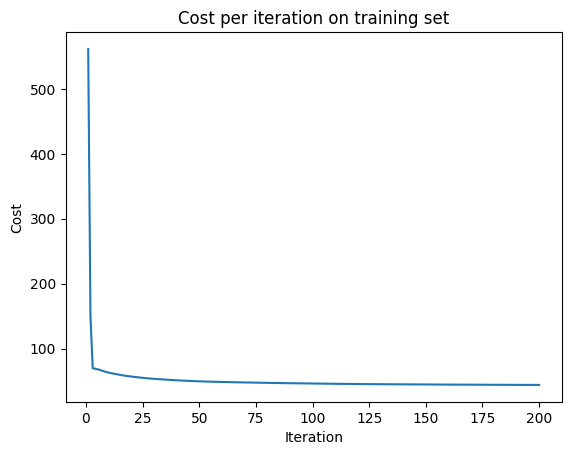

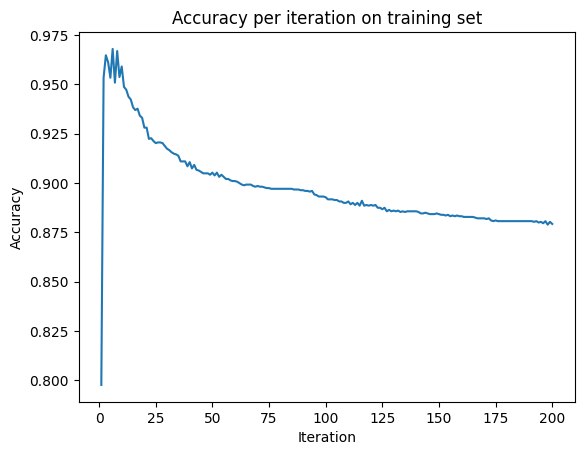

Accuracy score of the test data :  0.8891129032258065
F1 score of the test data :  0.5528455284552846


In [11]:
# Train the model
import sklearn.metrics

costs, model = linear_gd_train(train_X_cls, train_y_cls)
train_y_preds = linear_predict(train_X_cls, model[len(model)-1])

training_data_accuracy = model_accuracy( train_y_preds, train_y_cls)
training_f1_score = f1_score(train_y_preds, train_y_cls)

print('Accuracy score of the training data : ', training_data_accuracy)
print('F1 score of the training data : ', training_f1_score)

# Plot accuracy and cost per iteration on training set

x_points = np.arange(1,len(model))
plt.plot(x_points, costs)
plt.title("Cost per iteration on training set")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

accuracies = []
for i in range(1,len(model)):
    train_y_preds = linear_predict(train_X_cls, model[i])
    accuracies.append(model_accuracy(train_y_preds, train_y_cls))

plt.plot(x_points, accuracies)
plt.title("Accuracy per iteration on training set")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

# Apply imputation to the test set

test_X_icls = imputer.transform(test_X_cls)
test_X_icls = scaler.transform(test_X_icls)

# Predict on test set, report accuracy and f1 score

test_y_preds = linear_predict(test_X_icls, model[len(model)-1])
testing_data_accuracy = model_accuracy( test_y_preds, test_y_cls)
testing_f1_score = f1_score(test_y_preds, test_y_cls)


print('Accuracy score of the test data : ', testing_data_accuracy)
print('F1 score of the test data : ', testing_f1_score)


### 2.2 Learning Rate Analysis

The learning rate $\eta$ (Greek letter "eta") is a key parameter that affects the model training and performance. This is an experiment to demonstrate the effect of $\eta$ on model training, and on the model performance during testing.

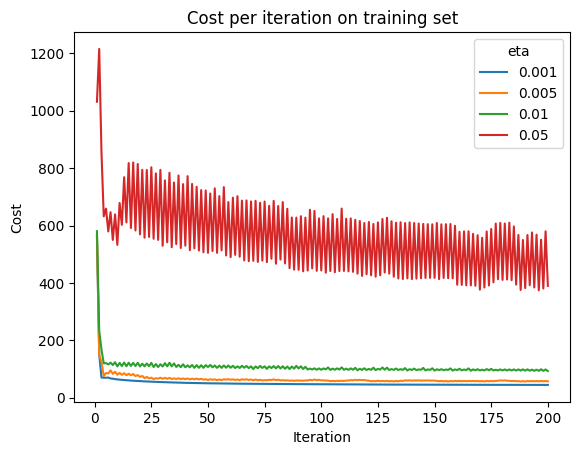

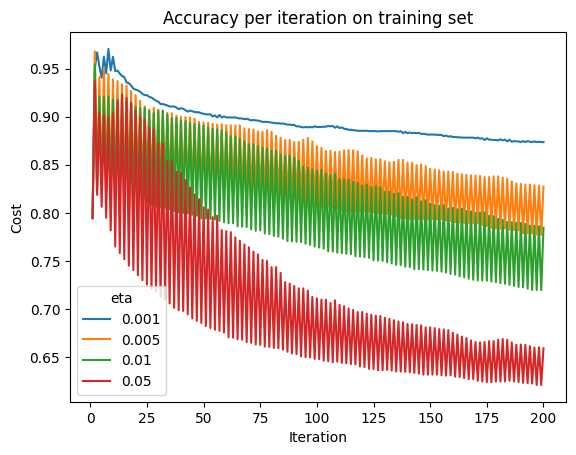

Accuracy on test set
eta = 0.001: accuracy = 0.8971774193548387
eta = 0.005: accuracy = 0.8528225806451613
eta = 0.01: accuracy = 0.8104838709677419
eta = 0.05: accuracy = 0.6512096774193549
F1 score on test set
eta = 0.001: F1 score = 0.5714285714285715
eta = 0.005: F1 score = 0.48226950354609927
eta = 0.01: F1 score = 0.41975308641975306
eta = 0.05: F1 score = 0.2821576763485477


In [6]:
learning_rates = np.array([0.001,0.005,0.01,0.05])

all_costs = []
all_accuracies = []
test_accuracies = []
test_f1scores = []
for eta in learning_rates:
    costs, model = linear_gd_train(train_X_cls,train_y_cls,learning_rate=eta)
    all_costs.append(costs)
    accuracies = []
    for i in range(1, len(model)):
        accuracies.append(model_accuracy(linear_predict(train_X_cls, model[i]), train_y_cls))
    all_accuracies.append(accuracies)
    x_points = np.arange(1,len(model))
    prediction_test = linear_predict(test_X_icls, model[len(model)-1])
    test_accuracies.append("eta = " + str(eta) + ": accuracy = "+ str(model_accuracy(prediction_test,test_y_cls)))    
    test_f1scores.append("eta = " + str(eta) + ": F1 score = "+ str(f1_score(prediction_test,test_y_cls)))  

for i in range(len(all_costs)):
    plt.plot(x_points,all_costs[i],label=learning_rates[i])
plt.title("Cost per iteration on training set")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend(title="eta")
plt.show()

for i in range(len(all_accuracies)):
    plt.plot(x_points,all_accuracies[i],label=learning_rates[i])
plt.title("Accuracy per iteration on training set")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend(title="eta")
plt.show()

print("Accuracy on test set")
for t in test_accuracies:
    print(t)

print("F1 score on test set")
for f in test_f1scores:
    print(f)
    


## 3. Air Quality Analysis by Neural Network


### 3.1 Simple MLP Model Selection 

This section is focused on the practical aspects of MLP implementation and model selection. We will first compare some model architectures. 

The set of MLP architectures to select is specified in `param_grid` below, including two MLPs with one hidden layer, where one has a small number of 3 hidden neurons, while the other has a larger number of 100 hidden neurons, and two MLPs with two hidden layers, where one is small (3, 3) and the other is larger (100, 100). It also includes two activation function options, i.e., the logistic and the rectified linear unit ("relu").  These result in a total of 8 model options, where sklearn default parameters are used for all the MLPs and their training. 

In [7]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {   
        'hidden_layer_sizes': [(3,), (100,), (3, 3), (100, 100)],
        'activation': ['relu', 'logistic'],
    },
]

In [8]:
# Redo split for regression
data = pd.read_excel("sensor_data.xlsx")
X=data.drop(columns=["CO(GT)"]).to_numpy()
Y=data["CO(GT)"].to_numpy()

train_X_reg, test_X_reg, train_y_reg, test_y_reg = sklearn.model_selection.train_test_split(X, Y, test_size=0.15)

# Prepare the data

imputer = SimpleImputer(missing_values=-999, strategy='mean')
scaler = sklearn.preprocessing.StandardScaler()

train_X_reg = imputer.fit_transform(train_X_reg)
train_X_reg = scaler.fit_transform(train_X_reg)

test_X_reg = imputer.transform(test_X_reg)
test_X_reg = scaler.transform(test_X_reg)

# Define MLP model

model = MLPRegressor()

# Initialise and fit the grid search

grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='neg_mean_squared_error')
grid.fit(train_X_reg,train_y_reg)


# Report the best parameters and the CV results

print("CV Results: ")
print(grid.cv_results_)
print("Best params: ")
print(grid.best_params_)

# Report model performance
new_model = MLPRegressor(**grid.best_params_)
new_model.fit(train_X_reg,train_y_reg)
print("MSE for testing set: " + str(sklearn.metrics.mean_squared_error(test_y_reg,new_model.predict(test_X_reg))))
print("R^2 score for testing set: " + str(sklearn.metrics.r2_score(test_y_reg,new_model.predict(test_X_reg))))



C:\Users\danci\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\danci\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\danci\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\danci\A

CV Results: 
{'mean_fit_time': array([0.38970675, 1.21640601, 0.49186039, 2.78904266, 0.40111957,
       2.5942718 , 0.55631037, 4.56458216]), 'std_fit_time': array([0.03594361, 0.01083874, 0.01304949, 0.14050035, 0.00741107,
       0.23084735, 0.01143716, 0.87021476]), 'mean_score_time': array([0.        , 0.        , 0.        , 0.00148101, 0.00150409,
       0.00204911, 0.00046325, 0.00406756]), 'std_score_time': array([0.        , 0.        , 0.        , 0.00139795, 0.00139742,
       0.00123083, 0.0004549 , 0.0049823 ]), 'param_activation': masked_array(data=['relu', 'relu', 'relu', 'relu', 'logistic', 'logistic',
                   'logistic', 'logistic'],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_hidden_layer_sizes': masked_array(data=[(3,), (100,), (3, 3), (100, 100), (3,), (100,), (3, 3),
                   (100, 100)],
             mask=[False, False, False, False, False, False, False, 

### 3.2 Training Algorithm Comparison: SGD and ADAM

We will compare two training algorithms, stochastic gradient descent (SGD) and ADAM optimisation, for training an MLP with two hidden layers each containing 100 neurons with "relu" activation, under the settings specified in `test_params` as below.

In [9]:
test_params = [
    {
        'activation': 'relu', 
        'alpha': 0.001, 
        'early_stopping': False, 
        'hidden_layer_sizes': (100, 100), 
        'solver': 'adam'
    },{
        'activation': 'relu', 
        'alpha': 0.001, 
        'early_stopping': False, 
        'hidden_layer_sizes': (100, 100), 
        'learning_rate': 'adaptive', 
        'momentum': 0.95, 
        'solver': 'sgd'
    },
]

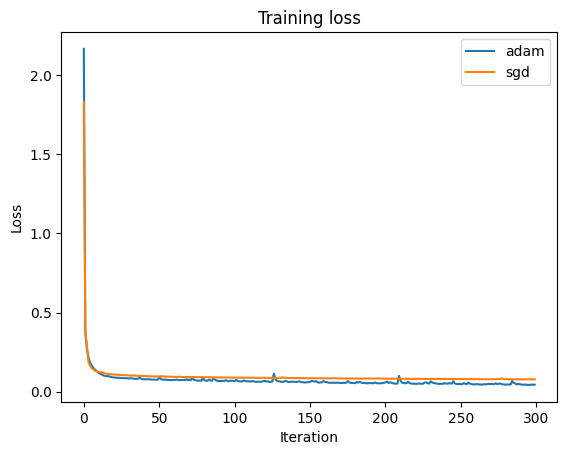

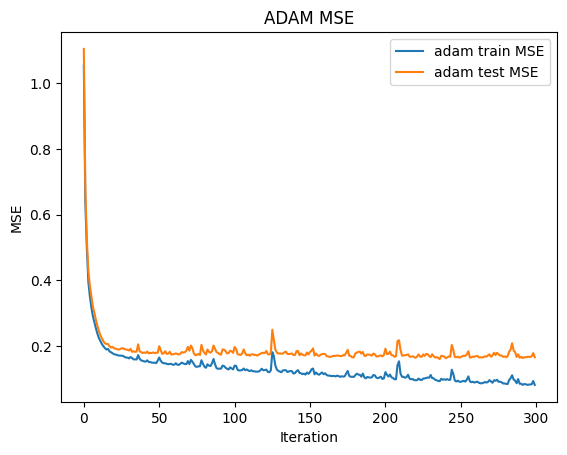

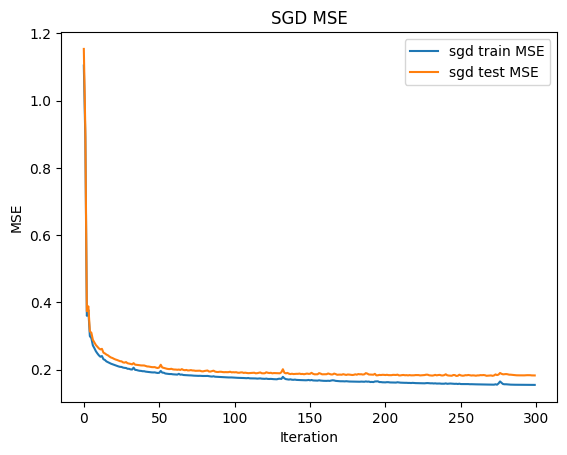

ADAM:
MSE:  0.1656549482251799
R2 score:  0.9169757086811364
SGD:
MSE:  0.18291774810172065
R2 score:  0.9083237985433184


In [10]:
# Train models and plot learning curves
adam = MLPRegressor(**test_params[0])
sgd = MLPRegressor(**test_params[1])

max_iters = 300
adamTrainMSE = []
adamTestMSE = []
sgdTrainMSE = []
sgdTestMSE = []

for i in range(max_iters):
    adam.partial_fit(train_X_reg, train_y_reg)
    sgd.partial_fit(train_X_reg, train_y_reg)
    adamTrainMSE.append(sklearn.metrics.mean_squared_error(train_y_reg, adam.predict(train_X_reg)))
    sgdTrainMSE.append(sklearn.metrics.mean_squared_error(train_y_reg, sgd.predict(train_X_reg)))
    adamTestMSE.append(sklearn.metrics.mean_squared_error(test_y_reg, adam.predict(test_X_reg)))
    sgdTestMSE.append(sklearn.metrics.mean_squared_error(test_y_reg, sgd.predict(test_X_reg)))


adamLoss = adam.loss_curve_
sgdLoss = sgd.loss_curve_

adam_x = np.arange(max_iters)
sgd_x = np.arange(max_iters)
adamLossLine = plt.plot(adam_x, np.array(adamLoss), label="adam")
sgdLossLine = plt.plot(sgd_x, np.array(sgdLoss), label="sgd")
plt.title("Training loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

adamTrainLine = plt.plot(adam_x, np.array(adamTrainMSE), label ="adam train MSE")
adamTestLine = plt.plot(adam_x, np.array(adamTestMSE), label ="adam test MSE")
plt.title("ADAM MSE")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()

sgdTrainLine = plt.plot(adam_x, np.array(sgdTrainMSE), label ="sgd train MSE")
sgdTestLine = plt.plot(adam_x, np.array(sgdTestMSE), label ="sgd test MSE")
plt.title("SGD MSE")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()

# Print final test set performance for both models

print("ADAM:")
print("MSE: ", sklearn.metrics.mean_squared_error(test_y_reg, adam.predict(test_X_reg)))
print("R2 score: ", sklearn.metrics.r2_score(test_y_reg, adam.predict(test_X_reg)))

print("SGD:")
print("MSE: ", sklearn.metrics.mean_squared_error(test_y_reg, sgd.predict(test_X_reg)))
print("R2 score: ", sklearn.metrics.r2_score(test_y_reg, sgd.predict(test_X_reg)))


## 4.  Build A Robust MLP Regressor

In this last experiment, we will develop a robust MLP regressor to predict the CO(GT) value based on the other 11 variables, using the provided dataset. This robust regressor should account for the presence of missing and noisy features. 

### 4.1 Model Development


In [11]:
# Your code here
from sklearn.pipeline import Pipeline

data = pd.read_excel("sensor_data.xlsx")
X = data.drop(columns=["CO(GT)"]).to_numpy()
Y = data["CO(GT)"].to_numpy()

train_X_mp, test_X_mp, train_y_mp, test_y_mp = sklearn.model_selection.train_test_split(X, Y, test_size=0.15)

pipe = Pipeline(steps=[("imputer",SimpleImputer(missing_values=-999)),("scaler",sklearn.preprocessing.StandardScaler()),("mlpregressor",MLPRegressor())])

mlp_param_grid = [
    {   
        'imputer__strategy' : ['mean','median','most_frequent'],
        'mlpregressor__hidden_layer_sizes': [(3,), (100,), (3, 3), (100, 100)],
        'mlpregressor__solver': ['adam'],
        'mlpregressor__activation': ['relu', 'logistic','identity','tanh'],
        'mlpregressor__alpha' : [0.01,0.001],
        'mlpregressor__learning_rate': ['constant', 'invscaling', 'adaptive'],
        'mlpregressor__momentum': [0.99],
        'mlpregressor__early_stopping':[False],
    },
]

# Initialise and fit the grid search

mlp = GridSearchCV(estimator=pipe, param_grid=mlp_param_grid,scoring='neg_mean_squared_error',n_jobs=-1)
mlp.fit(train_X_mp,train_y_mp)
mlp.best_estimator_.fit(train_X_mp,train_y_mp)



Pipeline(steps=[('imputer', SimpleImputer(missing_values=-999)),
                ('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(alpha=0.01, hidden_layer_sizes=(100, 100),
                              learning_rate='adaptive', momentum=0.99))])

In [13]:
print(f"Total notebook run time: {time.time() - notebook_start_time:.0f} seconds")

Total notebook run time: 369 seconds
